# Импорт библиотек и загрузка данных

In [1]:
!pip install pymorphy2
!pip install --upgrade scikit-learn
!pip install --upgrade keras
!pip install gensim


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 46.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=37c91bef4764e56143e572cf6481eb4a18985a80959c905e1b3222e8ab017025
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.ndimage import uniform_filter1d
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import time
%matplotlib inline

import pickle

from wordcloud import WordCloud, STOPWORDS

import nltk
nltk.download("stopwords")
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer 
from nltk.stem.snowball import SnowballStemmer

import re
import keras
import pymorphy2
import string
from string import punctuation
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA, TruncatedSVD


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
read_data = pd.read_csv("data.csv")

In [4]:
data = read_data.copy()
data.head()

,text,label
0,"В данный момент пишу диплом на тему ""моделиров...",process
1,Стараюсь вникнуть в основу продуктового менедж...,process
2,Я два раза участвовала в кейсах по маркетингу ...,result
3,Мы с командой вели проект по разработке прилож...,process
4,Мы с командой создали проект по разработке при...,result


# Предобработка данных

In [5]:
def get_corpus(text):
    corpus = []
    for sent in text:
        for word in sent.split():
            corpus.append(word)
    return corpus

def draw_word_cloud(corpus):
    text = ' '.join(corpus)
    wordcloud = WordCloud(width=3000, height=2000, max_words=200, random_state=42,
                              background_color='white', collocations=False).generate(text)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

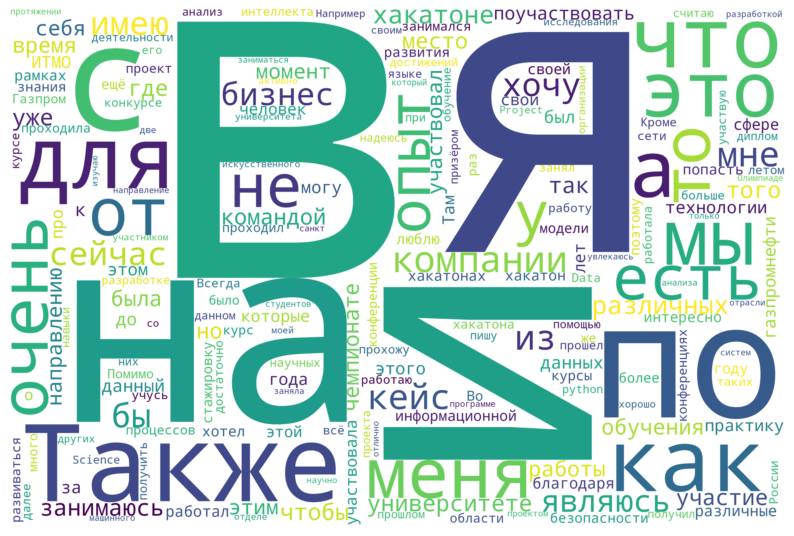

In [6]:
corpus = get_corpus(data['text'].values)
draw_word_cloud(corpus)

In [7]:
num_words = len(set(corpus))
print("Количество уникальных слов в корпусе: ", num_words)

Количество уникальных слов в корпусе:  2903


In [8]:
morph = pymorphy2.MorphAnalyzer()

def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()

    # Удаление символов, кроме буквенно-цифровых
    text = re.sub(r"[^\w\s]", "", text)

    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('russian'))

    lemmatized_tokens = []
    for token in tokens:
        parsed_token = morph.parse(token)[0]
        if 'VERB' in parsed_token.tag:
            lemmatized_tokens.append(parsed_token.tag.aspect) # вид глагола
        if parsed_token.normal_form.isdigit():
            lemmatized_tokens.append('num') # числа

        # Удаление стоп-слов, лемматизация и стемминг
        if not parsed_token.normal_form.isdigit() and parsed_token.normal_form not in stop_words:
            lemma = SnowballStemmer('russian').stem(parsed_token.normal_form)
            lemmatized_tokens.append(lemma)            

    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

In [9]:
# Пример
print(preprocess_text("«Я в& июне взял и поставил ОпяТЬ рекорд ПО выпитым Литрам воды - целых 134!!!"))

июн perf взят perf постав рекорд вып литр вод цел num


In [10]:
data['clean'] = data['text'].map(lambda x : preprocess_text(x))
data['label_num'] = data['label'].apply(lambda x: 1 if x == 'result' else 0)
data = data[['clean', 'label_num', 'label']]
tokenizer = RegexpTokenizer(r'\w+')
data['tokens'] = data['clean'].apply(tokenizer.tokenize)
data.head(5)
data = data.dropna() 
data = data.reset_index(drop=True)
data.head(5)

,clean,label_num,label,tokens
0,дан момент impf писа дипл тем моделирован проц...,0,process,"[дан, момент, impf, писа, дипл, тем, моделиров..."
1,impf стара вникнут основ продуктов менеджмент ...,0,process,"[impf, стара, вникнут, основ, продуктов, менед..."
2,impf участвова кейс маркетинг реклам пиар об p...,1,result,"[impf, участвова, кейс, маркетинг, реклам, пиа..."
3,команд вел проект разработк приложен анализ те...,0,process,"[команд, вел, проект, разработк, приложен, ана..."
4,команд perf созда проект разработк приложен ан...,1,result,"[команд, perf, созда, проект, разработк, прило..."


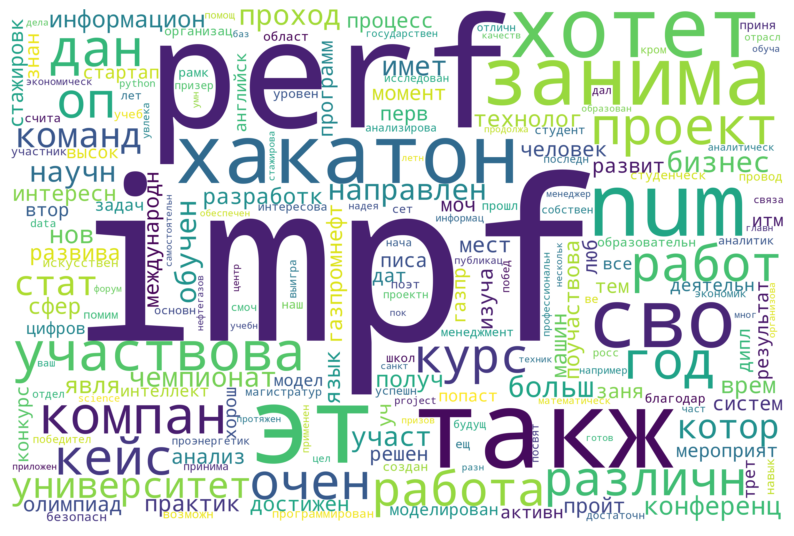

In [11]:
corpus_clean = get_corpus(data['clean'].values)
draw_word_cloud(corpus_clean)

In [12]:
num_words = len(set(corpus_clean))
print("Количество уникальных слов в корпусе: ", num_words)

Количество уникальных слов в корпусе:  1520


In [13]:
# Соотношение классов
data.groupby('label').count()

,clean,label_num,tokens
label,,,
process,292,292,292
result,240,240,240


Выборка сбалансированна. В том числе благодаря ручной аугментации при ее составлении.

# Выбор способа векторизации текста

In [14]:
corpus = data['clean'].tolist()
labels = data['label_num'].tolist()
X_train, X_test, y_train, y_test = train_test_split(corpus, labels, test_size=0.1, random_state=40) # 1:9

count_vectorizer = CountVectorizer()


In [15]:
def get_metrics(y_test, y_predicted):  
    precision = precision_score(y_test, y_predicted, average='weighted') # TP / (TP + FP)            
    recall = recall_score(y_test, y_predicted, average='weighted') # TP / (TP + FN)
    
    f1 = f1_score(y_test, y_predicted, average='weighted')
    
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1
    

In [16]:
def important_features(vectorizer, model, n=10):
    result = {}
    index_to_word = {x: a for a, x in vectorizer.vocabulary_.items()}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i, el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key=lambda x: x[0], reverse=True)
        result[class_index] = {'top': sorted_coeff[:n], 'bottom': sorted_coeff[-n:]}
    return result

def show_words_top_important(top_scores, top_words, bottom_scores, bottom_words):
    tmp = range(len(top_words))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

    ax1.barh(tmp, bottom_scores, color='skyblue')
    ax1.set_title('Process', fontsize=12)
    ax1.set_yticks(tmp)
    ax1.set_yticklabels(bottom_words, fontsize=10)
    ax1.set_xlabel('Weight', fontsize=10)
    
    ax2.barh(tmp, top_scores, color='salmon')
    ax2.set_title('Result', fontsize=12)
    ax2.set_yticks(tmp)
    ax2.set_yticklabels(top_words, fontsize=10)
    ax2.set_xlabel('Weight', fontsize=10)
    
    fig.suptitle("Most weighted-words", fontsize=16)
    plt.subplots_adjust(wspace=0.8)
    plt.show()

In [17]:
def plot_LSA(test_data, test_labels, method):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    colors = ['firebrick', 'slateblue']
    plt.scatter(lsa_scores[:, 0], lsa_scores[:, 1], s=20, alpha=0.6, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
    plt.legend(handles=[mpatches.Patch(color='firebrick', label='Result'), mpatches.Patch(color='slateblue', label='Process')])
    plt.xlabel('LSA Component 1')
    plt.ylabel('LSA Component 2')
    plt.title('LSA Plot for ' + method)

## Bag of words + Логистическая регрессия

In [18]:
X_train_bof = count_vectorizer.fit_transform(X_train)
X_test_bof = count_vectorizer.transform(X_test)

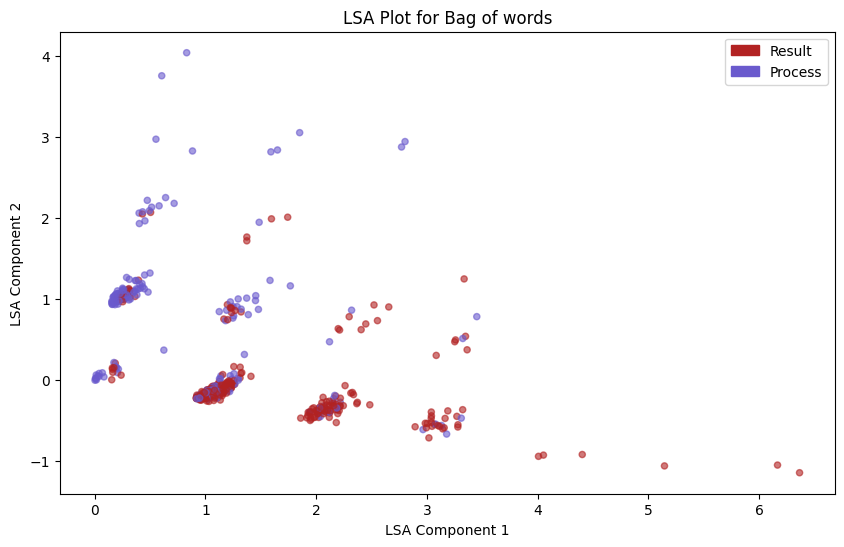

In [19]:
fig = plt.figure(figsize=(10, 6))
plot_LSA(X_train_bof, y_train, "Bag of words")
plt.show()


Здесь можно видеть график LSA, демонстрирующий как данные разделены на классы в пространстве двух компонент LSA. Визуализация позволяет увидеть, насколько успешно классы разделяются на основе доступных признаков. Здесь видно, что классы очень хорошо дифференцируются.

In [20]:
start_time = time.time()

param_grid = {
        'C': np.logspace(0, 3, 10),
        'max_iter': [100],
        'class_weight': ['balanced'],
        'multi_class': ['multinomial'],
        'n_jobs' : [-1]
    }

grid_search = GridSearchCV(LogisticRegression(), param_grid,
                            scoring='accuracy', cv=StratifiedKFold(n_splits=5))
grid_search.fit(X_train_bof, y_train)

best_params = grid_search.best_params_
print("Best params =", best_params)
print("Best score =", grid_search.best_score_) # по кросс-валидации
print()
logreg_clf_bof = grid_search.best_estimator_

end_time = time.time()
total_time = end_time - start_time
print("Общее время обучения модели:", total_time, "секунд")

y_predicted_bof = logreg_clf_bof.predict(X_test_bof)


Best params = {'C': 464.15888336127773, 'class_weight': 'balanced', 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': -1}
Best score = 0.7782675438596491

Общее время обучения модели: 4.283967733383179 секунд


In [21]:
print("Train accuracy = ", accuracy_score(y_train, logreg_clf_bof.predict(X_train_bof)))
print("Test accuracy = ", accuracy_score(y_test, logreg_clf_bof.predict(X_test_bof)))
print()
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_bof)
print("accuracy = %.5f, precision = %.5f, recall = %.5f, f1 = %.5f" % (accuracy, precision, recall, f1))


Train accuracy =  1.0
Test accuracy =  0.8333333333333334

accuracy = 0.83333, precision = 0.84722, recall = 0.83333, f1 = 0.83305


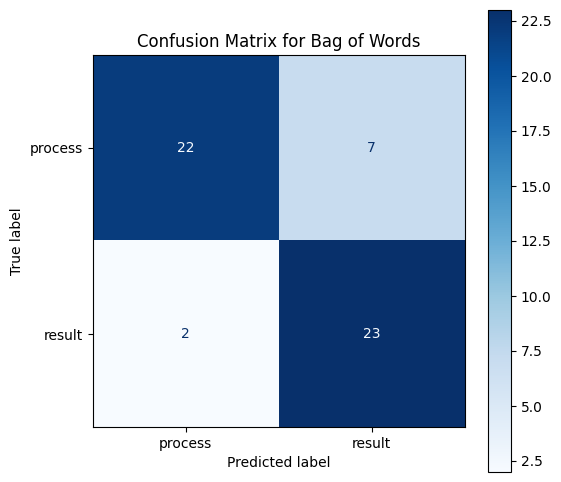

In [22]:
cm = confusion_matrix(y_test, logreg_clf_bof.predict(X_test_bof))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['process', 'result'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix for Bag of Words")
plt.show()

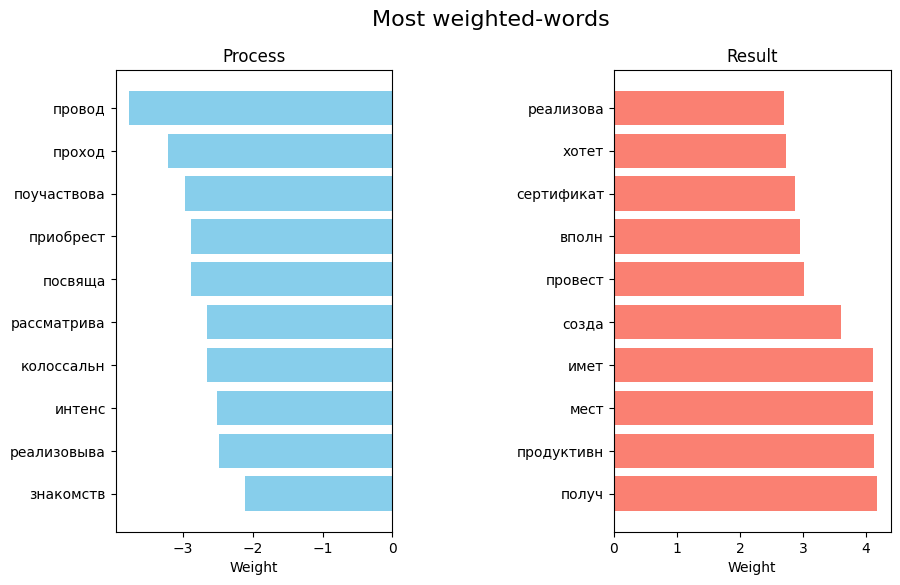

In [23]:
important = important_features(count_vectorizer, logreg_clf_bof)[0]

top_scores = [_[0] for _ in important['top']]
bottom_scores = [_[0] for _ in important['bottom']]
top_words = [_[1] for _ in important['top']]
bottom_words = [_[1] for _ in important['bottom']]

show_words_top_important(top_scores, top_words, bottom_scores, bottom_words)


Это не тот результат, который ожидался от модели: более весомыми должны были быть введенные теги, но здесь нет ни одного из них. Объяснимость модели с подобной векторизацией текста неудовлетворительна.

In [24]:
y_train_np = np.array(y_train)

def outlie_accuracy(model, X, y, threshold = 0.5):
    predictions = model.predict(X)
    probabilities = model.predict_proba(X)[:, 1]  # Вероятности принадлежности к классу "result"

    outliers = X[probabilities > threshold]  # Выбросы - примеры с вероятностью превышающей threshold

    outlier_predictions = predictions[probabilities > threshold]  # Предсказания для выбросов
    correctly_classified = outlier_predictions == y[probabilities > threshold]  # Корректно классифицированные выбросы

    accuracy_with_outliers = accuracy_score(y, predictions)
    accuracy_without_outliers = accuracy_score(y[probabilities <= threshold], predictions[probabilities <= threshold])
    return accuracy_with_outliers, accuracy_without_outliers

In [25]:
accuracy_with_outliers, accuracy_without_outliers = outlie_accuracy(logreg_clf_bof, X_train_bof, y_train_np)
print("Точность с выбросами  = ", accuracy_with_outliers)
print("Точность без выбросов  = ", accuracy_without_outliers)


Точность с выбросами  =  1.0
Точность без выбросов  =  1.0


## TF-IDF + Bag of words + Логистическая регрессия

In [26]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tf = tfidf_vectorizer.fit_transform(X_train)
X_test_tf = tfidf_vectorizer.transform(X_test)

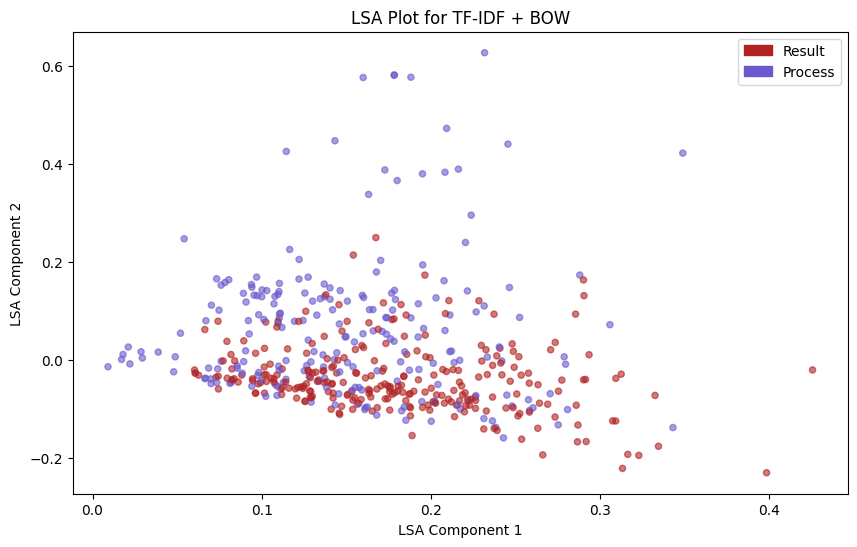

In [27]:
fig = plt.figure(figsize=(10, 6))
plot_LSA(X_train_tf, y_train, "TF-IDF + BOW")
plt.show()

Здесь можно наблюдать менее точное разделение между цветами. Однако объекты менее "скучкованы" и картина более ясна.

In [28]:
start_time = time.time()

param_grid = {
        'C': np.logspace(0, 3, 10),
        'max_iter': [100],
        'class_weight': ['balanced'],
        'multi_class': ['multinomial'],
        'n_jobs' : [-1]
    }

grid_search = GridSearchCV(LogisticRegression(), param_grid,
                            scoring='accuracy', cv=StratifiedKFold(n_splits=5))
grid_search.fit(X_train_tf, y_train)

best_params = grid_search.best_params_
print("Best params =", best_params)
print("Best score =", grid_search.best_score_)
print()
logreg_clf_tf = grid_search.best_estimator_

end_time = time.time()
total_time = end_time - start_time
print("Общее время обучения модели:", total_time, "секунд")

y_predicted_tf = logreg_clf_tf.predict(X_test_tf)

Best params = {'C': 4.641588833612778, 'class_weight': 'balanced', 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': -1}
Best score = 0.7845394736842104

Общее время обучения модели: 2.192370891571045 секунд


In [29]:
print("Train accuracy = ", accuracy_score(y_train, logreg_clf_tf.predict(X_train_tf)))
print("Test accuracy = ", accuracy_score(y_test, logreg_clf_tf.predict(X_test_tf)))
print()
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_tf)
print("accuracy = %.5f, precision = %.5f, recall = %.5f, f1 = %.5f" % (accuracy, precision, recall, f1))


Train accuracy =  0.99581589958159
Test accuracy =  0.8148148148148148

accuracy = 0.81481, precision = 0.82381, recall = 0.81481, f1 = 0.81481


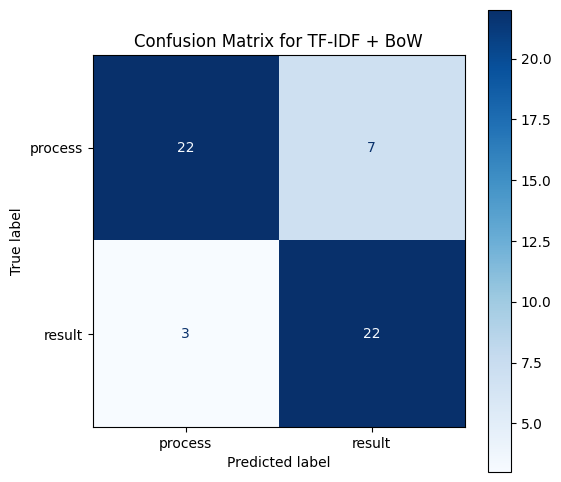

In [30]:
cm = confusion_matrix(y_test, logreg_clf_tf.predict(X_test_tf))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['process', 'result'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix for TF-IDF + BoW")
plt.show()

Ожидания не опрадались. По какой-то причине наложение tf-idf ухудшило результат. Проверим, насколько релевантно это изменение:

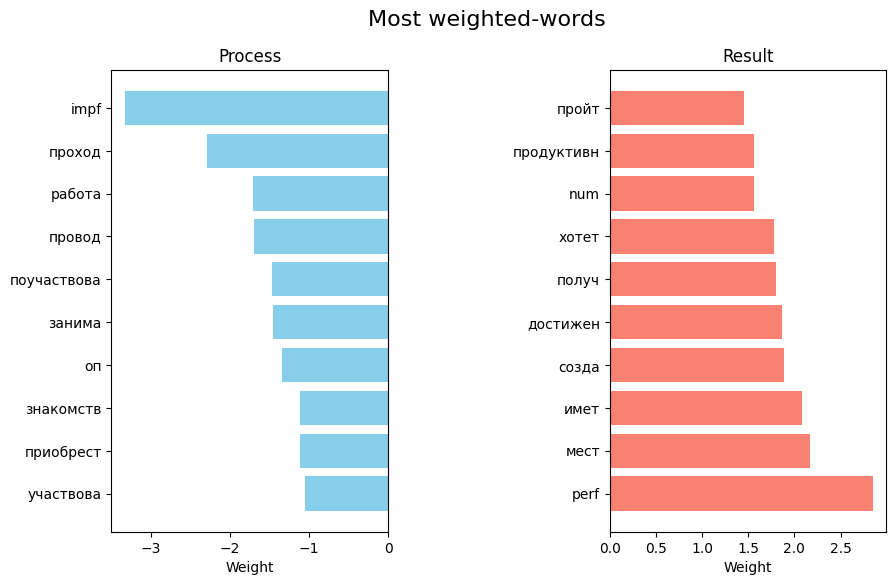

In [31]:
important = important_features(count_vectorizer, logreg_clf_tf)[0]
top_scores = [_[0] for _ in important['top']]
bottom_scores = [_[0] for _ in important['bottom']]
top_words = [_[1] for _ in important['top']]
bottom_words = [_[1] for _ in important['bottom']]
show_words_top_important(top_scores, top_words, bottom_scores, bottom_words)


Судя по весам слов на графике выше, все логично и улучшилось по сравнению с обычной векторизацией без наложения поверх TF-IDF. Информация о форме глагола играет очень важную роль в этой задаче, для этого мы и ввели этот признак вручную. Поэтому сейчас мы жертвуем точностью модели (0.81481 против 0.83333) в пользу качества модели и улучшения ее ожидаемого поведения на новых данных. Возможно, имело место переобучение или острая реакция на выбросы, потому как в выборке могут часто появляться некоторые слова в силу специфики выборки, но в предыдущем варианте это проявилось сильнее.

In [32]:
accuracy_with_outliers, accuracy_without_outliers = outlie_accuracy(logreg_clf_tf, X_train_tf, y_train_np)
print("Точность с выбросами  = ", accuracy_with_outliers)
print("Точность без выбросов  = ", accuracy_without_outliers)


Точность с выбросами  =  0.99581589958159
Точность без выбросов  =  1.0


## Word2Vec + Логистическая регрессия

In [33]:
start_time = time.time()

processed_texts = [text.split() for text in X_train]
model = Word2Vec(processed_texts, min_count=1)

X_train_w2v = []
for doc in processed_texts:
    doc_vector = np.mean([model.wv[word] for word in doc if word in model.wv], axis=0)
    X_train_w2v.append(doc_vector)

X_train_w2v = np.array(X_train_w2v)

param_grid = {
        'C': np.logspace(0, 3, 10),
        'max_iter': [100],
        'class_weight': ['balanced'],
        'multi_class': ['multinomial'],
        'n_jobs' : [-1]
    }

grid_search = GridSearchCV(LogisticRegression(), param_grid,
                            scoring='accuracy', cv=StratifiedKFold(n_splits=5))
grid_search.fit(X_train_w2v, y_train)

best_params = grid_search.best_params_
print("Best params =", best_params)
print("Best score =", grid_search.best_score_)
print()
logreg_clf_w2v = grid_search.best_estimator_

end_time = time.time()
total_time = end_time - start_time
print("Общее время обучения модели:", total_time, "секунд")


Best params = {'C': 1000.0, 'class_weight': 'balanced', 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': -1}
Best score = 0.6966447368421053

Общее время обучения модели: 1.666869878768921 секунд


In [34]:
processed_texts_test = [text.split() for text in X_test]
X_test_w2v = []
for doc in processed_texts_test:
    doc_vector = np.mean([model.wv[word] for word in doc if word in model.wv], axis=0)
    X_test_w2v.append(doc_vector)
X_test_w2v = np.array(X_test_w2v)

print("Train accuracy = ", accuracy_score(y_train, logreg_clf_w2v.predict(X_train_w2v)))
print("Test accuracy = ", accuracy_score(y_test, logreg_clf_w2v.predict(X_test_w2v)))
print()
y_predicted_tf = logreg_clf_w2v.predict(X_test_w2v)
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_tf)
print("accuracy = %.5f, precision = %.5f, recall = %.5f, f1 = %.5f" % (accuracy, precision, recall, f1))


Train accuracy =  0.7677824267782427
Test accuracy =  0.7962962962962963

accuracy = 0.79630, precision = 0.80164, recall = 0.79630, f1 = 0.79651


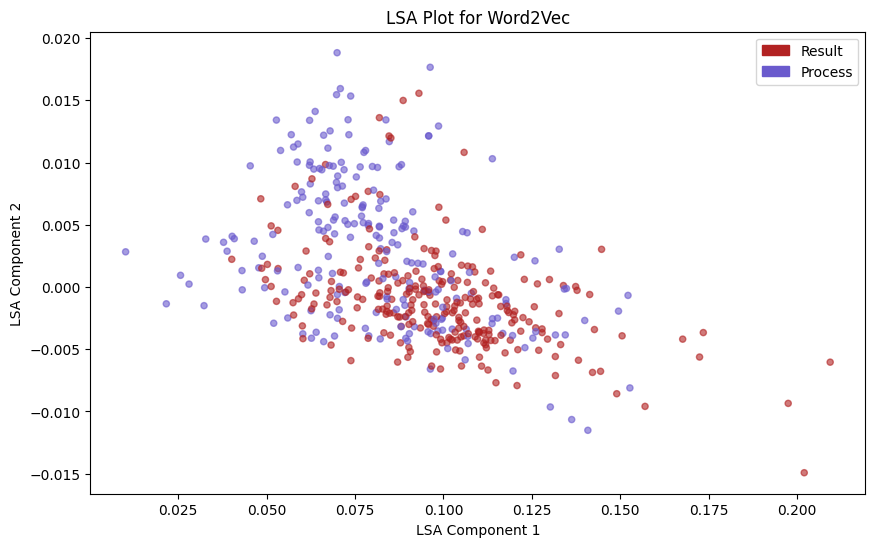

In [35]:
fig = plt.figure(figsize=(10, 6))
plot_LSA(X_train_w2v, y_train, "Word2Vec")
plt.show()

Стало хуже и это объяснимо. Больше на этой выборке использовать Word2Vec нет смысла, потому что она маленькая. Более того, очень странно себя ведет Learning Curve, стоит заметить, что такое поведение непредсказуемо в дальнейшем.

In [36]:
accuracy_with_outliers, accuracy_without_outliers = outlie_accuracy(logreg_clf_w2v, X_train_w2v, y_train_np)
print("Точность с выбросами  = ", accuracy_with_outliers)
print("Точность без выбросов  = ", accuracy_without_outliers)


Точность с выбросами  =  0.7677824267782427
Точность без выбросов  =  0.7923076923076923


In [37]:
word_vectors = model.wv.vectors
kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(word_vectors)
pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)
fig = px.scatter(x=word_vectors_pca[:, 0], y=word_vectors_pca[:, 1], color=clusters, hover_name=model.wv.index_to_key)
fig.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Слова перемешаны и мало поддается объяснению именно такое смешение. Такое векторное представление слов действительно не подходит для небольших выборок

## Вывод

Итак, вывод по примененным нами способам представить текст числено: 

Лучшие показатели точности логистическая регрессия дает с Bag of words, однако корректно с точки зрения весов отдельных токенов и отсюда более объяснимо она себя ведет с комбинацией TF-IDF + Bag of words. Выводы о подобной обработке текста делаются на основе логистической регресси потому, что она универсальна и более ясна в трактовании тех или иных ее параметров, чем многие другие алгоритмы.

**В дальнейшем будет использовано сочетание TF-IDF + Bag of words.**

# Выбор модели


## Multinomual Naive Bayes

In [38]:
def mnb_train_model(X_train, y_train):
    alphas = np.linspace(0.1, 1.0, 20)
    fit_prior_options = [True, False]
    class_prior_options = [None, [0.2, 0.8], [0.4, 0.6], [0.6, 0.4], [0.8, 0.2]]
    
    param_grid = {
        'alpha': alphas,
        'fit_prior': fit_prior_options,
        'class_prior': class_prior_options
    }
    grid_search = GridSearchCV(MultinomialNB(), param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=5))
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    print("Best parameters:", best_params)
    print("Best score =", grid_search.best_score_)
    print()
    model = grid_search.best_estimator_
    
    return model


In [39]:
start_time - time.time()

mnb_clf_tf = mnb_train_model(X_train_tf, y_train)

end_time = time.time()
total_time = end_time - start_time
print("Общее время обучения модели:", total_time, "секунд")
print()
y_predicted_tf = mnb_clf_tf.predict(X_test_tf)

print("Train accuracy = ", accuracy_score(y_train, mnb_clf_tf.predict(X_train_tf)))
print("Test accuracy = ", accuracy_score(y_test, y_predicted_tf))
print()
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_tf)
print("accuracy = %.5f, precision = %.5f, recall = %.5f, f1 = %.5f" % (accuracy, precision, recall, f1))

Best parameters: {'alpha': 0.9526315789473684, 'class_prior': None, 'fit_prior': False}
Best score = 0.7573245614035087

Общее время обучения модели: 9.47325325012207 секунд

Train accuracy =  0.9602510460251046
Test accuracy =  0.7777777777777778

accuracy = 0.77778, precision = 0.78052, recall = 0.77778, f1 = 0.77808


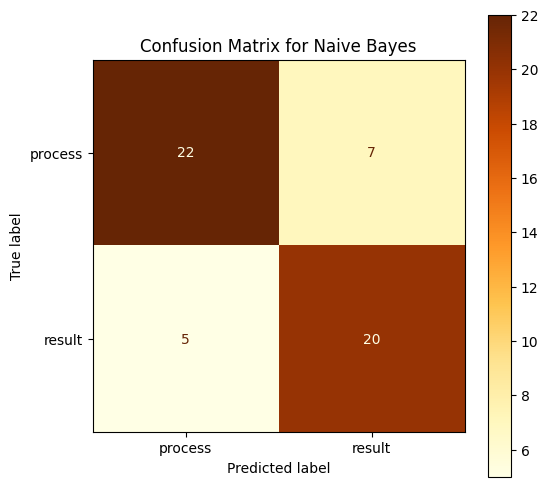

In [40]:
cm = confusion_matrix(y_test, mnb_clf_tf.predict(X_test_tf))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['process', 'result'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='YlOrBr')
plt.title("Confusion Matrix for Naive Bayes")
plt.show()

## Метод опорных векторов

In [41]:
def svm_train_model(X_train, y_train):
    param_grid = {
        'C': np.logspace(0, 2, 10),
        'kernel': ['linear', 'rbf', 'poly'],
        'degree': [1, 2],
        'class_weight': ['balanced'],
        'probability' : [True]
    }
    grid_search = GridSearchCV(SVC(), param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=5))
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print("Best params =", best_params)
    print("Best score =", grid_search.best_score_)
    print()
    model = grid_search.best_estimator_

    return model


In [42]:
start_time = time.time()

svm_clf_tf = svm_train_model(X_train_tf, y_train)

end_time = time.time()
total_time = end_time - start_time
print("Общее время обучения модели:", total_time, "секунд")
print()
y_predicted_tf = svm_clf_tf.predict(X_test_tf)

print("Train accuracy = ", accuracy_score(y_train, svm_clf_tf.predict(X_train_tf)))
print("Test accuracy = ", accuracy_score(y_test, y_predicted_tf))
print()
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_tf)
print("accuracy = %.5f, precision = %.5f, recall = %.5f, f1 = %.5f" % (accuracy, precision, recall, f1))

Best params = {'C': 12.91549665014884, 'class_weight': 'balanced', 'degree': 1, 'kernel': 'rbf', 'probability': True}
Best score = 0.7762061403508772

Общее время обучения модели: 34.26996612548828 секунд

Train accuracy =  1.0
Test accuracy =  0.8148148148148148

accuracy = 0.81481, precision = 0.82381, recall = 0.81481, f1 = 0.81481


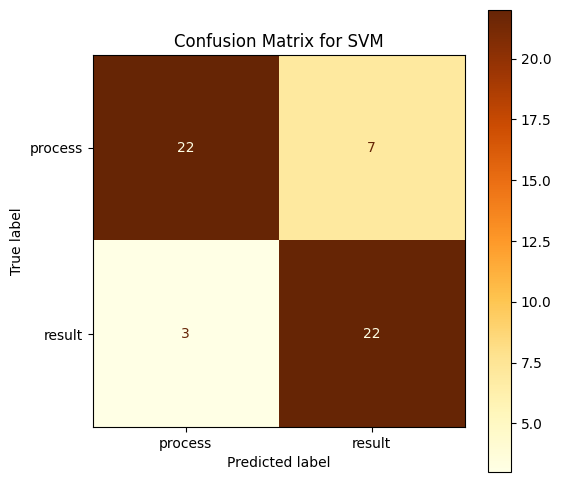

In [43]:
cm = confusion_matrix(y_test, svm_clf_tf.predict(X_test_tf))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['process', 'result'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='YlOrBr')
plt.title("Confusion Matrix for SVM")
plt.show()

## Метод k ближайших соседей

In [44]:
def knn_train_model(X_train, y_train):
    param_grid = {
        'n_neighbors': [3, 5, 7],
        'p': [1, 2]
    }
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=5))
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print("Best params =", best_params)
    print("Best score =", grid_search.best_score_)
    print()
    model = grid_search.best_estimator_

    return model


In [45]:
start_time = time.time()

knn_clf_tf = knn_train_model(X_train_tf, y_train)

end_time = time.time()
total_time = end_time - start_time
print("Общее время обучения модели:", total_time, "секунд")
print()
y_predicted_tf = knn_clf_tf.predict(X_test_tf)

print("Train accuracy = ", accuracy_score(y_train, knn_clf_tf.predict(X_train_tf)))
print("Test accuracy = ", accuracy_score(y_test, y_predicted_tf))
print()
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_tf)
print("accuracy = %.5f, precision = %.5f, recall = %.5f, f1 = %.5f" % (accuracy, precision, recall, f1))

Best params = {'n_neighbors': 5, 'p': 2}
Best score = 0.7657017543859649

Общее время обучения модели: 0.44596362113952637 секунд

Train accuracy =  0.8702928870292888
Test accuracy =  0.6481481481481481

accuracy = 0.64815, precision = 0.65288, recall = 0.64815, f1 = 0.64851


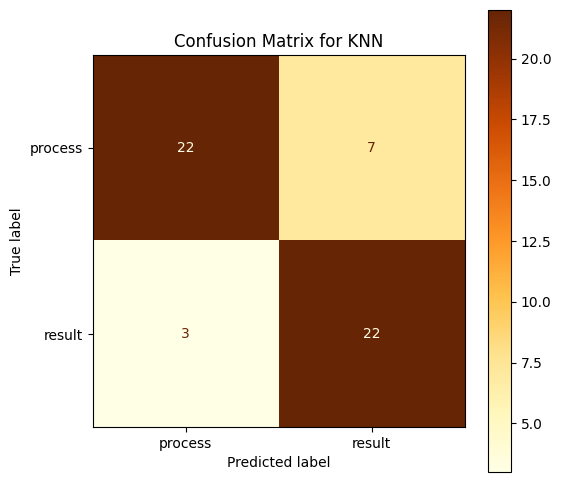

In [46]:
cm = confusion_matrix(y_test, svm_clf_tf.predict(X_test_tf))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['process', 'result'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='YlOrBr')
plt.title("Confusion Matrix for KNN")
plt.show()

## Случайный лес

In [47]:
def rf_train_model(X_train, y_train):
    param_grid = {
        'n_estimators' : [100],
        'max_depth': range(1,11),
        'max_features': [10]
    }
    
    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=5))
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    print("Best params =", best_params)
    print("Best score =", grid_search.best_score_)
    print()
    model = grid_search.best_estimator_

    return model


In [48]:
start_time = time.time()

rf_clf_tf = rf_train_model(X_train_tf, y_train)

end_time = time.time()
total_time = end_time - start_time
print("Общее время обучения модели:", total_time, "секунд")
print()
y_predicted_tf = rf_clf_tf.predict(X_test_tf)
print("Train accuracy = ", accuracy_score(y_train, rf_clf_tf.predict(X_train_tf)))
print("Test accuracy = ", accuracy_score(y_test, y_predicted_tf))
print()
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_tf)
print("accuracy = %.5f, precision = %.5f, recall = %.5f, f1 = %.5f" % (accuracy, precision, recall, f1))

Best params = {'max_depth': 10, 'max_features': 10, 'n_estimators': 100}
Best score = 0.6757894736842105

Общее время обучения модели: 9.352887153625488 секунд

Train accuracy =  0.8200836820083682
Test accuracy =  0.7037037037037037

accuracy = 0.70370, precision = 0.80905, recall = 0.70370, f1 = 0.66602


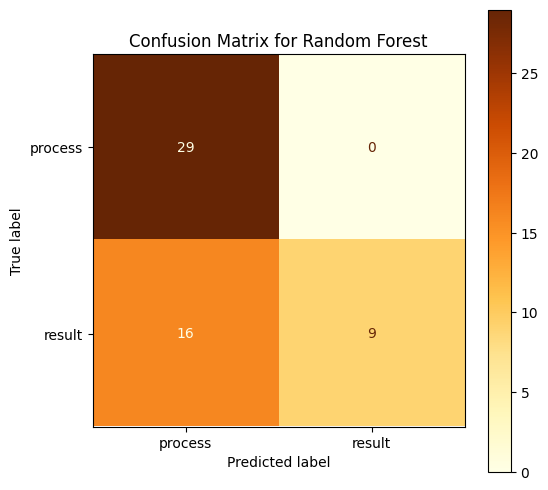

In [49]:
cm = confusion_matrix(y_test, rf_clf_tf.predict(X_test_tf))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['process', 'result'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='YlOrBr')
plt.title("Confusion Matrix for Random Forest")
plt.show()

## Градиентный бустинг

In [50]:
def gb_train_model(X_train, y_train):
    param_grid = {
        "learning_rate": [0.1, 0.3],
        'max_depth': range(1,7),
        "criterion": ["friedman_mse"],
        "n_estimators":[100]
    }
    
    grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=5))
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print("Best params =", best_params)
    print("Best score =", grid_search.best_score_)
    print()
    model = grid_search.best_estimator_
 
    return model


In [51]:
start_time = time.time()

gb_clf_tf = gb_train_model(X_train_tf, y_train)

end_time = time.time()
total_time = end_time - start_time
print("Общее время обучения модели:", total_time, "секунд")
print()
y_predicted_tf = gb_clf_tf.predict(X_test_tf)
print("Train accuracy = ", accuracy_score(y_train, gb_clf_tf.predict(X_train_tf)))
print("Test accuracy = ", accuracy_score(y_test, y_predicted_tf))
print()
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_tf)
print("accuracy = %.5f, precision = %.5f, recall = %.5f, f1 = %.5f" % (accuracy, precision, recall, f1))

Best params = {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Best score = 0.7532894736842106

Общее время обучения модели: 26.962969541549683 секунд

Train accuracy =  1.0
Test accuracy =  0.9074074074074074

accuracy = 0.90741, precision = 0.90822, recall = 0.90741, f1 = 0.90750


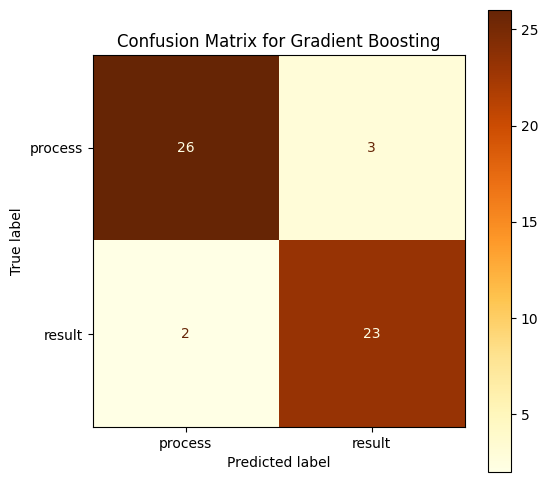

In [52]:
cm = confusion_matrix(y_test, gb_clf_tf.predict(X_test_tf))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['process', 'result'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='YlOrBr')
plt.title("Confusion Matrix for Gradient Boosting")
plt.show()

In [53]:
accuracy_with_outliers, accuracy_without_outliers = outlie_accuracy(gb_clf_tf, X_train_tf, y_train_np)
print("Точность с выбросами  = ", accuracy_with_outliers)
print("Точность без выбросов  = ", accuracy_without_outliers)

Точность с выбросами  =  1.0
Точность без выбросов  =  1.0


Как мы видим, модель очень устойчива к выбросам!

## Logistic Regression + SVM

In [54]:
start = time.time()

# Объединение моделей в ансамбль
voting_clf = VotingClassifier(
    estimators=[('svm', svm_clf_tf), ('logreg', logreg_clf_tf)],
    voting='soft'  # Используется усреднение вероятностей
)

# Поиск лучших параметров для ансамбля
param_grid = {
    'svm__C':  np.logspace(0, 2, 10),
    'svm__kernel': ['rbf'],
    'svm__degree': [1, 2],
    'logreg__C': np.logspace(0, 3, 10),
    'logreg__max_iter': [100],
    'voting': ['soft']
}

grid_search = GridSearchCV(voting_clf, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_tf, y_train)

best_params = grid_search.best_params_
print("Best params =", best_params)
print("Best score =", grid_search.best_score_)
print()

# Получение лучшей модели
svm_logreg_clf_tf = grid_search.best_estimator_

end_time = time.time()
total_time = end_time - start_time
print("Общее время обучения модели:", total_time, "секунд")
print()
y_predicted_tf = svm_logreg_clf_tf.predict(X_test_tf)

print("Train accuracy = ", accuracy_score(y_train, svm_logreg_clf_tf.predict(X_train_tf)))
print("Test accuracy = ", accuracy_score(y_test, svm_logreg_clf_tf.predict(X_test_tf)))
print()
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_tf)
print("accuracy = %.5f, precision = %.5f, recall = %.5f, f1 = %.5f" % (accuracy, precision, recall, f1))

Best params = {'logreg__C': 46.41588833612777, 'logreg__max_iter': 100, 'svm__C': 1.0, 'svm__degree': 1, 'svm__kernel': 'rbf', 'voting': 'soft'}
Best score = 0.78875

Общее время обучения модели: 198.868182182312 секунд

Train accuracy =  0.997907949790795
Test accuracy =  0.8333333333333334

accuracy = 0.83333, precision = 0.83883, recall = 0.83333, f1 = 0.83350


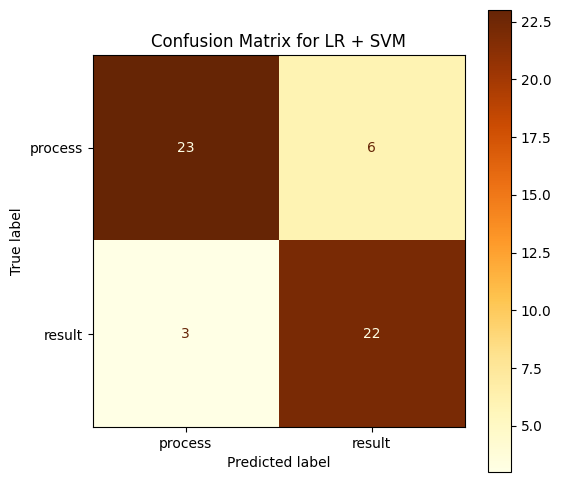

In [55]:
cm = confusion_matrix(y_test, y_predicted_tf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['process', 'result'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='YlOrBr')
plt.title("Confusion Matrix for LR + SVM")
plt.show()

## Logistic Regression + Naive Bayes

In [56]:
start = time.time()

# Объединение моделей в ансамбль
voting_clf = VotingClassifier(
    estimators=[('mnb', mnb_clf_tf), ('logreg', logreg_clf_tf)],
    voting='soft'  # Используется усреднение вероятностей
)

# Поиск лучших параметров для ансамбля
param_grid = {
    'mnb__alpha':  np.linspace(0.1, 1.0, 20),
    'mnb__fit_prior': [False],
    'mnb__class_prior': [[0.8, 0.2]],
    'logreg__C': np.logspace(0, 3, 10),
    'logreg__max_iter': [100],
    'voting': ['soft']
}

grid_search = GridSearchCV(voting_clf, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_tf, y_train)

best_params = grid_search.best_params_
print("Best params =", best_params)
print("Best score =", grid_search.best_score_)
print()

# Получение лучшей модели
mnb_logreg_clf_tf = grid_search.best_estimator_

end_time = time.time()
total_time = end_time - start_time
print("Общее время обучения модели:", total_time, "секунд")
print()
y_predicted_tf = mnb_logreg_clf_tf.predict(X_test_tf)

print("Train accuracy = ", accuracy_score(y_train, mnb_logreg_clf_tf.predict(X_train_tf)))
print("Test accuracy = ", accuracy_score(y_test, y_predicted_tf))
print()
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_tf)
print("accuracy = %.5f, precision = %.5f, recall = %.5f, f1 = %.5f" % (accuracy, precision, recall, f1))

Best params = {'logreg__C': 1000.0, 'logreg__max_iter': 100, 'mnb__alpha': 0.5263157894736842, 'mnb__class_prior': [0.8, 0.2], 'mnb__fit_prior': False, 'voting': 'soft'}
Best score = 0.7908552631578948

Общее время обучения модели: 248.43101954460144 секунд

Train accuracy =  1.0
Test accuracy =  0.8333333333333334

accuracy = 0.83333, precision = 0.83333, recall = 0.83333, f1 = 0.83305


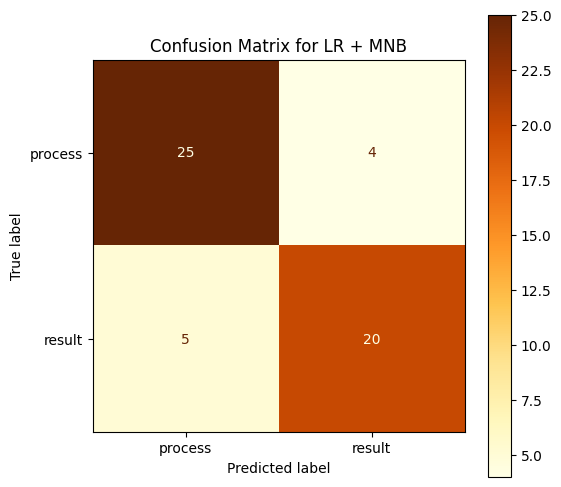

In [57]:
cm = confusion_matrix(y_test, y_predicted_tf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['process', 'result'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='YlOrBr')
plt.title("Confusion Matrix for LR + MNB")
plt.show()

## Логистическая Регрессия + GB

In [58]:
start = time.time()

# Объединение моделей в ансамбль
voting_clf = VotingClassifier(
    estimators=[('gb', gb_clf_tf), ('logreg', logreg_clf_tf)],
    voting='soft'  # Используется усреднение вероятностей
)
    
# Поиск лучших параметров для ансамбля
param_grid = {
    "gb__learning_rate": [0.1, 0.3],
    'gb__max_depth': range(1,7),
    "gb__criterion": ["friedman_mse"],
    "gb__n_estimators":[100],
    'logreg__C': np.logspace(0, 3, 10),
    'logreg__max_iter': [100],
    'voting': ['soft']
}

grid_search = GridSearchCV(voting_clf, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_tf, y_train)

best_params = grid_search.best_params_
print("Best params =", best_params)
print("Best score =", grid_search.best_score_)
print()

# Получение лучшей модели
gb_logreg_clf_tf = grid_search.best_estimator_

end_time = time.time()
total_time = end_time - start_time
print("Общее время обучения модели:", total_time, "секунд")
print()
y_predicted_tf = gb_logreg_clf_tf.predict(X_test_tf)

print("Train accuracy = ", accuracy_score(y_train, gb_logreg_clf_tf.predict(X_train_tf)))
print("Test accuracy = ", accuracy_score(y_test, y_predicted_tf))
print()
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_tf)
print("accuracy = %.5f, precision = %.5f, recall = %.5f, f1 = %.5f" % (accuracy, precision, recall, f1))

Best params = {'gb__criterion': 'friedman_mse', 'gb__learning_rate': 0.3, 'gb__max_depth': 2, 'gb__n_estimators': 100, 'logreg__C': 21.544346900318832, 'logreg__max_iter': 100, 'voting': 'soft'}
Best score = 0.7930482456140351

Общее время обучения модели: 531.5122046470642 секунд

Train accuracy =  1.0
Test accuracy =  0.9074074074074074

accuracy = 0.90741, precision = 0.91321, recall = 0.90741, f1 = 0.90750


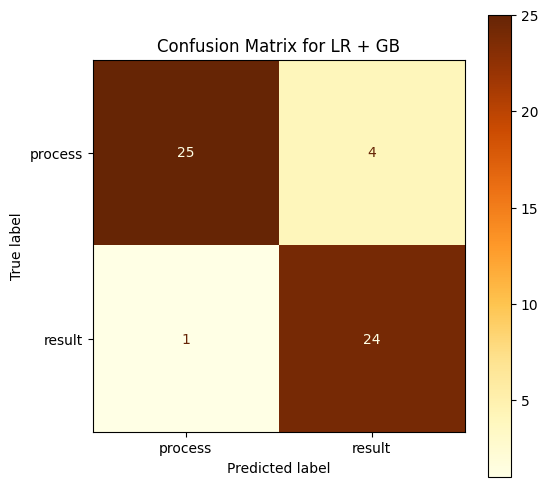

In [59]:
cm = confusion_matrix(y_test, y_predicted_tf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['process', 'result'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='YlOrBr')
plt.title("Confusion Matrix for LR + GB")
plt.show()

## Сравнение моделей

In [60]:
def show_learning_curve(model, name):
  train_sizes, train_scores, val_scores = learning_curve(model, X_train_tf, y_train, train_sizes=np.linspace(0.1, 1.0, 15), cv=StratifiedKFold(n_splits=5))

  train_scores_mean = np.mean(train_scores, axis=1)
  val_scores_mean = np.mean(val_scores, axis=1)

  train_trace = go.Scatter(x=train_sizes, y=train_scores_mean, mode='lines+markers', name='Training score', marker=dict(color='purple'), hovertemplate='Training Score: %{y}<extra></extra>')
  val_trace = go.Scatter(x=train_sizes, y=val_scores_mean, mode='lines+markers', name='Validation score', marker=dict(color='green'), hovertemplate='Training Score: %{y}<extra></extra>')
  fig = go.Figure(data=[train_trace, val_trace])
  fig.update_layout(
      title='Learning Curve ' + name,
      xaxis=dict(title='Training Set Size'),
      yaxis=dict(title='Accuracy Score'),
      legend=dict(x=1, y=0.05),
      width=1000,
      height=500,
  )
  fig.show()


Далее кривые обучения в порядке убывания точности модели:

In [61]:
show_learning_curve(gb_logreg_clf_tf, "Logistic Regression and Gradient Boosting")

In [62]:
show_learning_curve(gb_clf_tf, "Gradient Boosting")

In [63]:
show_learning_curve(svm_logreg_clf_tf, "Logistic Regression and SVM")

In [64]:
show_learning_curve(mnb_logreg_clf_tf, "Logistic Regression and Naive Bayes")

In [65]:
show_learning_curve(logreg_clf_tf, "Logistic Regression")

In [66]:
show_learning_curve(svm_clf_tf, "SVM")

## Вывод

Выбор остановим на **Градиентном бустинге**. Показатели у них с гибридной моделью того же GB и логистической регрессией одинаковые, но время обучения меньше в десятки порядков. 

Итоговые показатели модели: 

*   $accuracy = 0.90741$
*   $precision = 0.908226$
*   $recall = 0.90741$
*   $F1 = 0.90750$
*   $Training \space time \approx 45$$

Если расширять выборку, то, возможно, лучше рассмотреть и других моделях, не связанных с GB, поскольку кривые обучения у них возрастают заметней. Однако, это может быть обманчиво и на больших выборках GB все же выиграет.

# Сохраняем и пробуем модель

In [67]:
# Сохраняем модель и векторизатор в файлы
with open('gb_clf_tf.pkl', 'wb') as f:
    pickle.dump(gb_clf_tf, f)

with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)


In [68]:
# Загрузка модели для проверки
with open('gb_clf_tf.pkl', 'rb') as f:
    model = pickle.load(f)

with open('vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)


In [69]:
sentence_1 = preprocess_text("Я прошел практику, где многому научился и получил опыт") 
sentence_2 = preprocess_text("Я увлекаюсь рисованием!?")
sentence_3 = preprocess_text("Я очень боюсь пауков, но все равно заведу одного!")
sentence_4 = preprocess_text("Я очень боюсь пауков, но все равно думаю о том, чтобы завести одного...")

classes = {0 : 'process', 1 : 'result'}

prediction_1= model.predict(vectorizer.transform([sentence_1]))[0]
prediction_2= model.predict(vectorizer.transform([sentence_2]))[0]
prediction_3= model.predict(vectorizer.transform([sentence_3]))[0]
prediction_4= model.predict(vectorizer.transform([sentence_4]))[0]

print(classes[prediction_1])
print(classes[prediction_2])
print(classes[prediction_3])
print(classes[prediction_4])

result
process
result
process
